In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')
data_train_dir = '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
data_test_dir = '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
data_train_dir_path = pathlib.Path(data_train_dir)
data_test_dir_path = pathlib.Path(data_test_dir)
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [ ]:
image_count_train = len(list(data_train_dir_path.rglob('*/*.jpg')))
print(image_count_train)

2239


In [ ]:
image_count_test = len(list(data_test_dir_path.rglob('*/*.jpg')))
print(image_count_test)

118


In [ ]:
type(data_train_dir_path)

pathlib.PosixPath

## Load using keras.preprocessing

In [3]:
batch_size = 32
img_height = 180
img_weight = 180

In [ ]:
full_train_dataset = tf.keras.utils.image_dataset_from_directory(data_train_dir_path,image_size=(img_height,img_weight),batch_size=32,shuffle=True,seed=123)

Found 2239 files belonging to 9 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(data_test_dir_path
,image_size=(img_height,img_weight), batch_size=32, shuffle=False,seed=123)

Found 118 files belonging to 9 classes.


In [ ]:
class_names = full_train_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
class_names = test_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
type(full_train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
validation_split = 0.2

# Calculate the number of samples for validation
total_size = len(full_train_dataset) * 32  # Total number of samples
validation_size = int(total_size * validation_split)

# Create validation and training datasets
train_size = total_size - validation_size

# Split the dataset into training and validation datasets
train_ds = full_train_dataset.take(train_size // 32)  # Divide by batch size
val_ds = full_train_dataset.skip(train_size // 32)


In [ ]:
len(train_ds)

56

In [ ]:
len(val_ds)

14

In [ ]:
len(full_train_dataset)

70

In [ ]:
len(test_ds)

4

## Visualizing the Data

In [ ]:
import matplotlib.pyplot as plt

def plot_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        # Get a batch of images and labels
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            label = labels[i].numpy()

            # No need to scale, as images are already in [0, 255]
            plt.imshow(img.astype(np.uint8))
            plt.title(class_names[label.argmax()])
            plt.axis('off')

    plt.show()




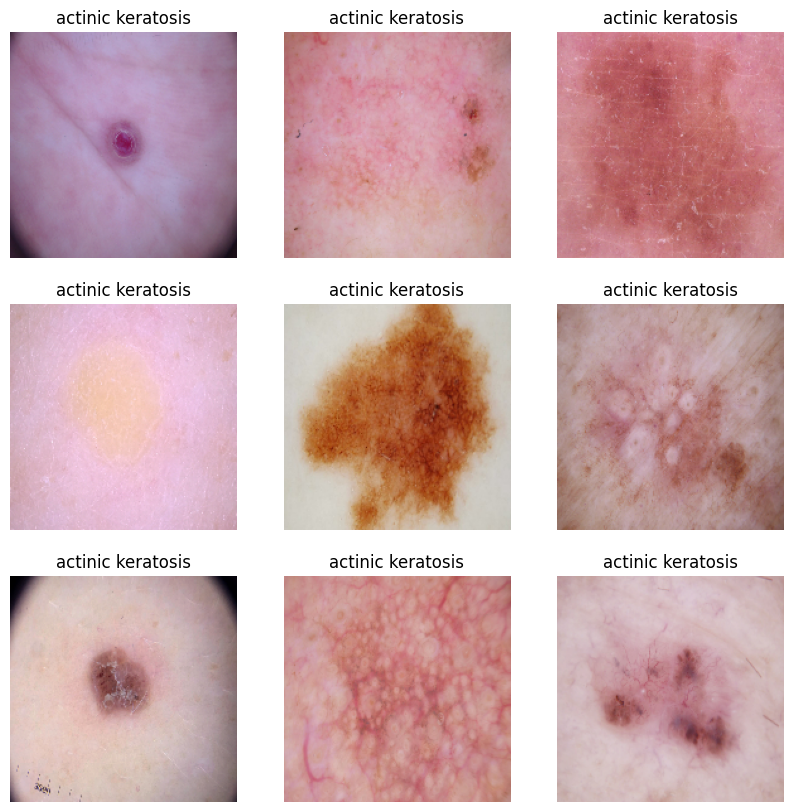

In [ ]:
plot_images(train_ds, class_names)

## Data Preprocessing

In [ ]:
AUTOTUNE =  tf.data.experimental.AUTOTUNE


# Apply preprocessing
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Define the model architecture
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(512, activation='relu'),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 631s 11s/step - accuracy: 0.2361 - loss: 2.0308 - val_accuracy: 0.3535 - val_loss: 1.7618
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3925 - loss: 1.6626 - val_accuracy: 0.4004 - val_loss: 1.6747
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4331 - loss: 1.5715 - val_accuracy: 0.4922 - val_loss: 1.5490
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4969 - loss: 1.4759 - val_accuracy: 0.4966 - val_loss: 1.5019
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4992 - loss: 1.4126 - val_accuracy: 0.4944 - val_loss: 1.4362
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5024 - loss: 1.3880 - val_accuracy: 0.4497 - val_loss: 1.6082
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5143 - loss: 1.4121 - val_accuracy: 0.4609 - val_loss: 1.4810
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5258 - loss: 1.3077 - val_accuracy: 0.4698 - 

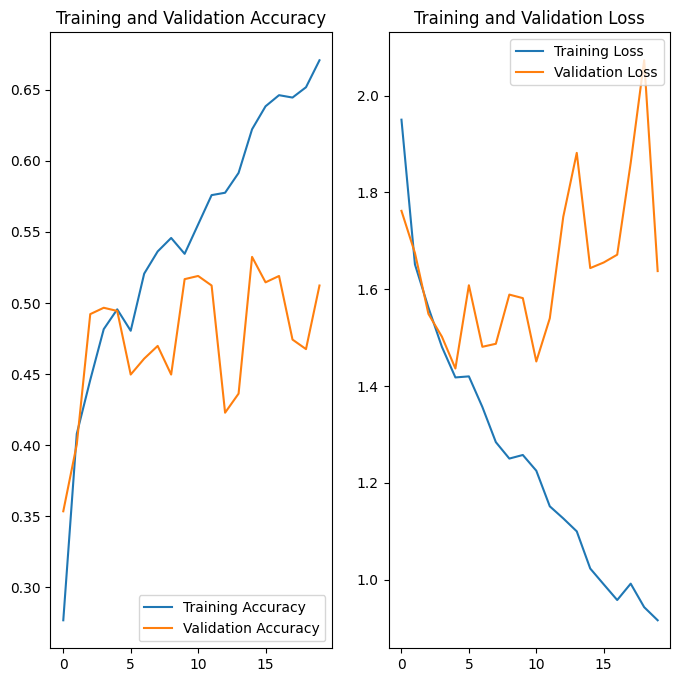

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Findings

## Findings
The output from above trianing shows


*   Trining Accuracy: 66.89% ->
Model is performing reasonably well on the training data.however, improvement can be done.
*   Validation Accuracy: 57.94% ->
Model is not up to the mark on validation set compare to training set.This is case of overfitting.
*   Trining Loss: 0.8864 ->
More improvement can be done.
*   Validation Loss: 2.1172 ->
Overfitting is observed.




<ipython-input-46-08ee9749e4c4>:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 5, i)


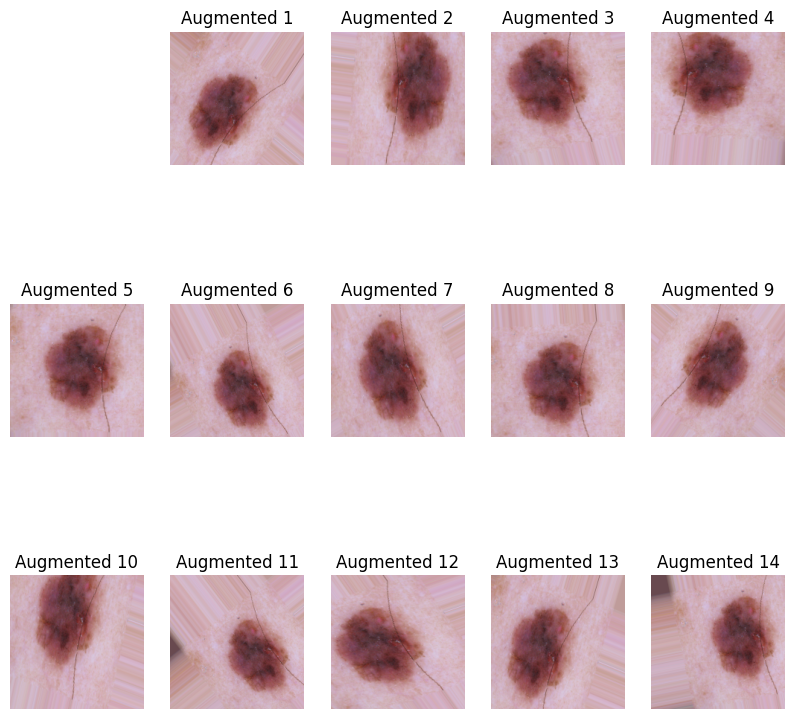

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0, 1]
    rotation_range=40,                # Rotate images
    width_shift_range=0.2,            # Shift images horizontally
    height_shift_range=0.2,           # Shift images vertically
    shear_range=0.2,                  # Apply shear transformation
    zoom_range=0.2,                   # Zoom into images
    horizontal_flip=True,             # Flip images horizontally
    fill_mode='nearest'               # Fill mode for new pixels
)

# Load a sample image
img_path = data_train_dir_path / 'melanoma/ISIC_0000139.jpg'
img = load_img(img_path, target_size=(180, 180))  # Load the image
x = img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Create a generator for the image
it = datagen.flow(x, batch_size=1)

# Plot the original image and augmented images
plt.figure(figsize=(10, 10))

# Plot the original image
plt.subplot(2, 5, 1)
plt.imshow(x[0] / 255.0)  # Rescale to [0, 1] for visualization
plt.title('Original Image')
plt.axis('off')

# Generate and plot augmented images
for i in range(2, 16):  # Generate 9 augmented images
    batch = next(it)  # Get the next batch from the iterator
    augmented_img = batch[0]
    plt.subplot(3, 5, i)
    plt.imshow(augmented_img)
    plt.title(f'Augmented {i-1}')
    plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.1968 - loss: 3.2811 - val_accuracy: 0.2215 - val_loss: 2.7455
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1949 - loss: 2.5927 - val_accuracy: 0.2215 - val_loss: 2.4470
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1972 - loss: 2.3716 - val_accuracy: 0.2215 - val_loss: 2.2870
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1970 - loss: 2.2435 - val_accuracy: 0.3333 - val_loss: 2.0378
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2994 - loss: 2.0165 - val_accuracy: 0.3087 - val_loss: 2.0566
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3393 - loss: 1.8999 - val_accuracy: 0.3870 - val_loss: 1.8332
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3729 - loss: 1.8105 - val_accuracy: 0.4318 - val_loss: 1.7142
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4066 - loss: 1.7067 - val_accuracy: 0.4273 - 

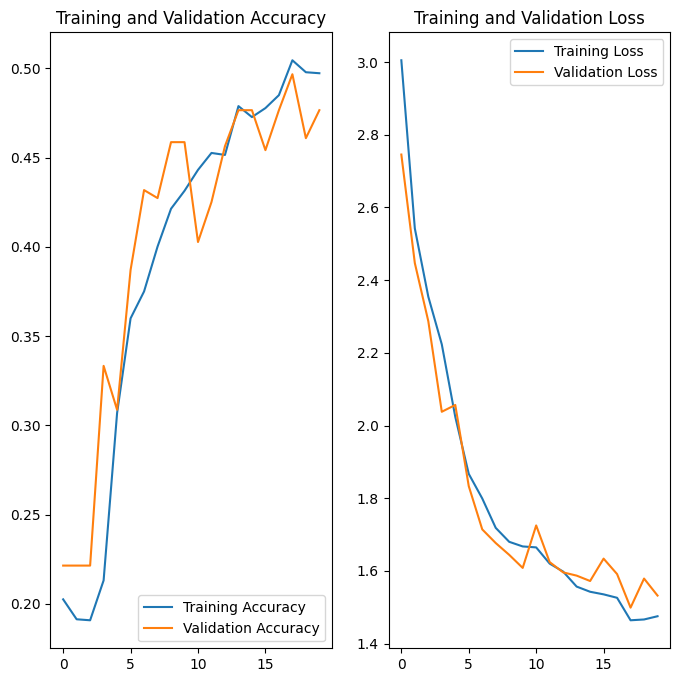

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dense(512, activation='relu'),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.1898 - loss: 2.1547 - val_accuracy: 0.3087 - val_loss: 2.0559
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3219 - loss: 1.8423 - val_accuracy: 0.3870 - val_loss: 1.7428
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3826 - loss: 1.6327 - val_accuracy: 0.3557 - val_loss: 1.7578
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4085 - loss: 1.6020 - val_accuracy: 0.4228 - val_loss: 1.6584
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4561 - loss: 1.5078 - val_accuracy: 0.4273 - val_loss: 1.6608
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4749 - loss: 1.4776 - val_accuracy: 0.4430 - val_loss: 1.6187
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4899 - loss: 1.4425 - val_accuracy: 0.3893 - val_loss: 1.6841
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4937 - loss: 1.4091 - val_accuracy: 0.4004 - v

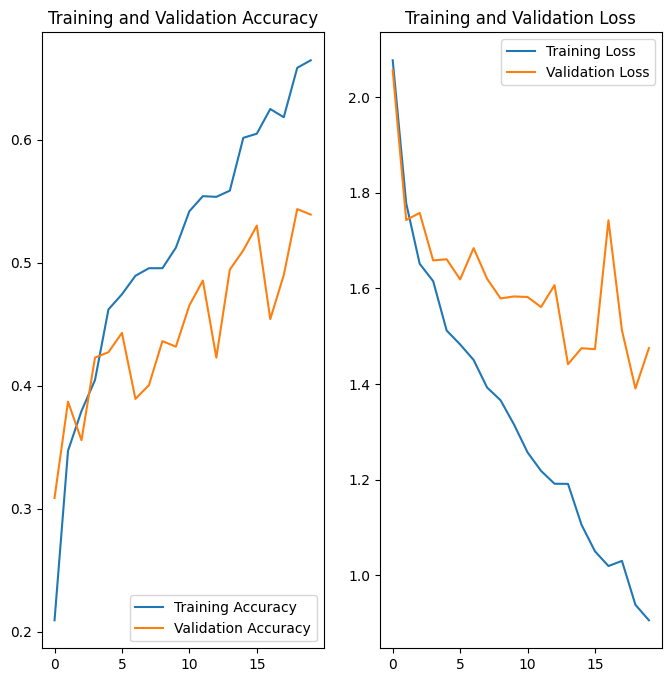

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install Augmentor

In [ ]:
import os



# Get a list of subdirectories (each representing a class)
class_names = os.listdir(data_train_dir_path)

# Dictionary to hold the count of images for each class
class_image_counts = {}

# Iterate through each class directory
for class_name in class_names:
    class_path = os.path.join(data_train_dir_path, class_name)

    # Check if the path is a directory
    if os.path.isdir(class_path):
        # List all files in the class directory
        files = os.listdir(class_path)

        # Count the number of image files (you can filter by extensions if needed)
        image_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Store the count in the dictionary
        class_image_counts[class_name] = image_count

# Print the counts for each class
for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}' has {count} images.")


Class 'actinic keratosis' has 114 images.
Class 'basal cell carcinoma' has 376 images.
Class 'dermatofibroma' has 95 images.
Class 'melanoma' has 438 images.
Class 'nevus' has 357 images.
Class 'pigmented benign keratosis' has 462 images.
Class 'seborrheic keratosis' has 77 images.
Class 'squamous cell carcinoma' has 181 images.
Class 'vascular lesion' has 139 images.


## Classes images count
* Class 'actinic keratosis' has 114 images.
* Class 'basal cell carcinoma' has 376 images.
* Class 'dermatofibroma' has 95 images.
* Class 'melanoma' has 438 images.
* Class 'nevus' has 357 images.
* Class 'pigmented benign keratosis' has 462 images.
* Class 'seborrheic keratosis' has 77 images.
* Class 'squamous cell carcinoma' has 181 images.
* Class 'vascular lesion' has 139 images.

## Least number of samples in below classes
* seborrheic keratosis
* dermatofibroma


## Classes dominate the data in terms of samples count
* pigmented benign keratosis
* melanoma

In [ ]:
from pathlib import Path
import Augmentor

# Define the path to your training dataset directory as a Path object
path_to_training_dataset = Path(data_train_dir_path)

# List of class names or subdirectories for each class
class_names = [d.name for d in path_to_training_dataset.iterdir() if d.is_dir()]

# Create Augmentor pipelines and apply augmentations
for class_name in class_names:
    class_path = path_to_training_dataset / class_name  # Use / operator to join paths
    p = Augmentor.Pipeline(str(class_path))  # Convert Path object to string

    # Apply various augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)

    # Generate and save augmented images
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A184F88E0>: 100%|██████████| 500/500 [00:21<00:00, 23.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A027E5D20>: 100%|██████████| 500/500 [00:29<00:00, 16.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A18518340>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D7A9C6DA5C0>: 100%|██████████| 500/500 [01:46<00:00,  4.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A9C0670D0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A9C6DA260>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D7A18752920>: 100%|██████████| 500/500 [00:47<00:00, 10.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A027E68F0>: 100%|██████████| 500/500 [00:21<00:00, 22.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7A9F16F970>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


In [14]:
full_train_dataset = tf.keras.utils.image_dataset_from_directory(data_train_dir_path,image_size=(img_height,img_weight),batch_size=32,shuffle=True,seed=123)

Found 6739 files belonging to 9 classes.


In [15]:
image_count_train = len(list(data_train_dir_path.rglob('*/*.jpg')))
print(image_count_train)

6739


In [ ]:
import glob
import os
# Generate list of image file paths using glob.glob()
path_list = [x for x in glob.glob(os.path.join(data_train_dir_path, '*', 'output', '*.jpg'))]

# Print the list of paths
print(path_list)

['/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_50c46899-20cc-4d48-9975-16a9ec55626b.jpg', '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_f40a7843-35f6-43cf-8c1e-7b5feff9d976.jpg', '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_66c5fab1-4e18-4c95-8d1c-ec815fa8e898.jpg', '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_56fdd99e-7c2c-4eac-9481-9013d762aa4e.jpg', '/content/drive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.j

In [16]:
validation_split = 0.2

# Calculate the number of samples for validation
total_size = len(full_train_dataset) * 32  # Total number of samples
validation_size = int(total_size * validation_split)

# Create validation and training datasets
train_size = total_size - validation_size

# Split the dataset into training and validation datasets
train_ds = full_train_dataset.take(train_size // 32)  # Divide by batch size
val_ds = full_train_dataset.skip(train_size // 32)

In [7]:
len(train_ds)

168

In [ ]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 78s 427ms/step - accuracy: 0.1594 - loss: 3.0036 - val_accuracy: 0.2517 - val_loss: 2.1366
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 70s 419ms/step - accuracy: 0.2723 - loss: 2.0582 - val_accuracy: 0.3668 - val_loss: 1.8048
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 70s 418ms/step - accuracy: 0.3390 - loss: 1.8360 - val_accuracy: 0.3676 - val_loss: 1.7392
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 74s 442ms/step - accuracy: 0.3861 - loss: 1.7105 - val_accuracy: 0.3874 - val_loss: 1.7158
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.4116 - loss: 1.6394 - val_accuracy: 0.4270 - val_loss: 1.6108
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.4156 - loss: 1.6415 - val_accuracy: 0.4431 - val_loss: 1.5769
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 71s 423ms/step - accuracy: 0.4344 - loss: 1.5637 - val_accuracy: 0.4725 - val_loss: 1.4934
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 72s 430ms/step - accuracy: 0.4399 - loss: 1

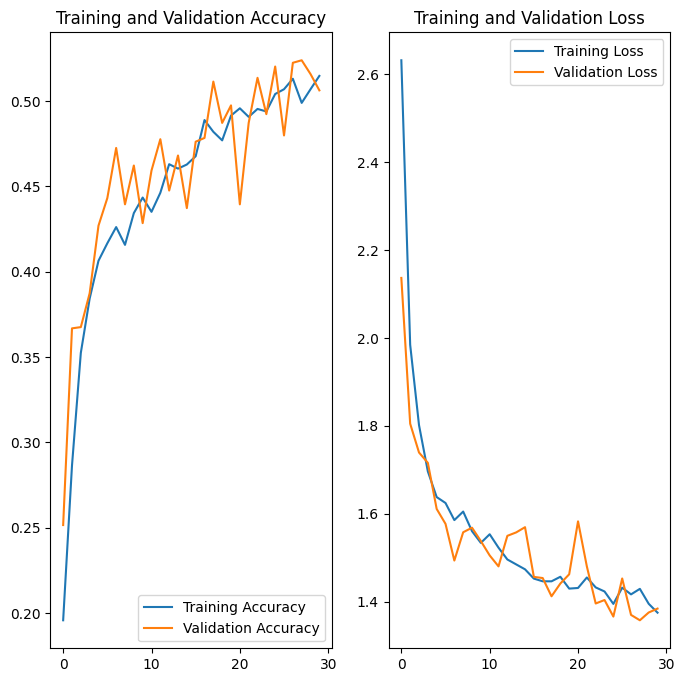

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 2345s 14s/step - accuracy: 0.1603 - loss: 2.2181 - val_accuracy: 0.3316 - val_loss: 1.8239
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 72s 432ms/step - accuracy: 0.3272 - loss: 1.7650 - val_accuracy: 0.3705 - val_loss: 1.7177
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.3842 - loss: 1.6151 - val_accuracy: 0.4160 - val_loss: 1.5947
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 67s 399ms/step - accuracy: 0.4049 - loss: 1.5579 - val_accuracy: 0.3910 - val_loss: 1.5558
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 72s 429ms/step - accuracy: 0.4347 - loss: 1.4901 - val_accuracy: 0.4226 - val_loss: 1.4848
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 68s 409ms/step - accuracy: 0.4381 - loss: 1.4512 - val_accuracy: 0.4153 - val_loss: 1.5307
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 72s 432ms/step - accuracy: 0.4321 - loss: 1.4199 - val_accuracy: 0.4652 - val_loss: 1.3767
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 414ms/step - accuracy: 0.4801 - loss: 1

In [17]:
AUTOTUNE =  tf.data.experimental.AUTOTUNE


# Apply preprocessing
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 439ms/step - accuracy: 0.1468 - loss: 2.2399 - val_accuracy: 0.1599 - val_loss: 2.1670
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.2410 - loss: 1.9381 - val_accuracy: 0.3698 - val_loss: 1.6762
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3581 - loss: 1.6688 - val_accuracy: 0.4028 - val_loss: 1.6089
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3938 - loss: 1.5871 - val_accuracy: 0.4439 - val_loss: 1.5320
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4128 - loss: 1.5122 - val_accuracy: 0.4365 - val_loss: 1.4955
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4510 - loss: 1.4593 - val_accuracy: 0.4321 - val_loss: 1.5275
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4483 - loss: 1.4360 - val_accuracy: 0.4519 - val_loss: 1.4513
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4831 - loss: 1.3503 - val

## Findings
- Only Dropout witout Regularizations used at every level.
- Training Accuracy - 79% and Validation Accuracy - 65%.
- Looks like Regularization is required to reducce furthur overfitting.

In [21]:
from tensorflow.keras import layers, models, regularizers

# Define the model architecture with dropout and L2 regularization
model = models.Sequential([
    # Input normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional layer with dropout
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    # Second convolutional layer with dropout
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    # Third convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    # Fourth convolutional layer with dropout
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    # Flatten the results
    layers.Flatten(),

    # Fully connected layer with dropout and regularization
    layers.Dropout(0.3),

    # Output layer with 9 classes
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │          93,321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,153 (1.27 MB)

 Trainable params: 334,153 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.1560 - loss: 2.3404 - val_accuracy: 0.2891 - val_loss: 1.9103
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3253 - loss: 1.8078 - val_accuracy: 0.3426 - val_loss: 1.7421
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3763 - loss: 1.6743 - val_accuracy: 0.4013 - val_loss: 1.5879
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4131 - loss: 1.5741 - val_accuracy: 0.4116 - val_loss: 1.5583
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4323 - loss: 1.5141 - val_accuracy: 0.3910 - val_loss: 1.5672
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4596 - loss: 1.4731 - val_accuracy: 0.4131 - val_loss: 1.5292
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4687 - loss: 1.4545 - val_accuracy: 0.4417 - val_loss: 1.4664
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4847 - loss: 1.4162 - val_ac

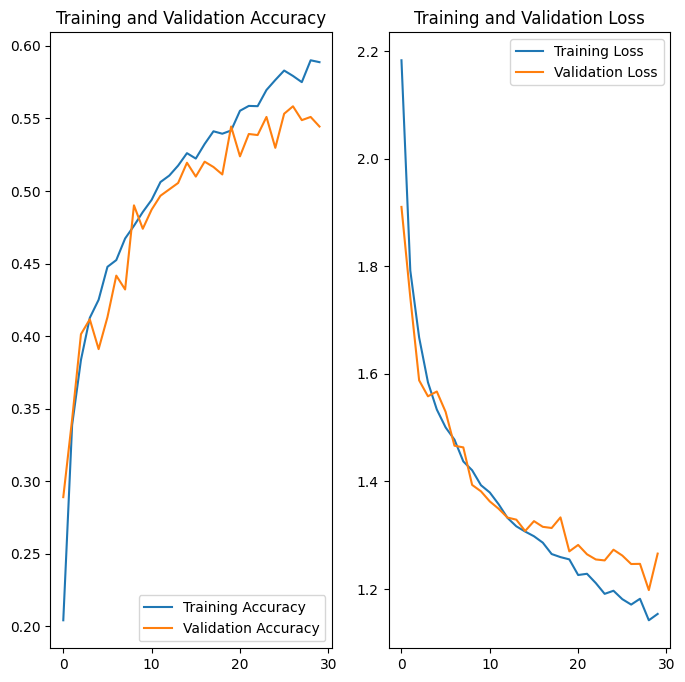

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
## Findings

## Findings
- Both dropout and Regularization technicques are used.
- Accuracy reached above 60%
- No overfitting or Underfitting.
